# Proposal 3

$$
\mathcal{L} = \mathcal{L}_c + \lambda_q \cdot || \bm{p} ||_1 + \lambda_e \cdot || \bm{p^*_A} \odot \bm{(\theta - \theta^*_A) }||_1 + \lambda_f \cdot || \bm{(1 - p)} \odot \bm{\theta} ||_1
$$

In [1]:
%load_ext autoreload
%autoreload 2

# Libraries

In [2]:
import pickle
import pandas as pd
import plotly.express as px
from tqdm import tqdm

In [3]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    bwt_metrics,
    confusion_matrix_metrics,
    forgetting_metrics,
    timing_metrics,
    cpu_usage_metrics,
    gpu_usage_metrics,
    disk_usage_metrics,
    ram_usage_metrics,
    loss_metrics,
    class_accuracy_metrics,
    accuracy_matrix_metrics
)

from torch.nn import CrossEntropyLoss
from torch.optim import SGD

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Custom Libraries

In [4]:
import sys

sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH
from base_code.training import MWUN
from base_code.plugins import WeightStoragePlugin

# Device

In [5]:
from torch import cuda
device = "cuda" if cuda.is_available() else "cpu"

# Dataset and definitions

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [6]:
scenario = PermutedMNIST(10, seed=1234, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [7]:
train_stream = scenario.train_stream
test_stream = scenario.test_stream

## Evaluation metrics definition

In [8]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(minibatch=True, experience=True, stream=True),
    gpu_usage_metrics(experience=True, stream=True, gpu_id=device),
    disk_usage_metrics(experience=True, stream=True),
    ram_usage_metrics(experience=True, stream=True),
    class_accuracy_metrics(experience=True, stream=True),
    accuracy_matrix_metrics(),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    confusion_matrix_metrics(stream=True, num_classes=scenario.n_classes),
    
    loggers=[InteractiveLogger()]
)

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")
/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")


## Plugin defitinitions

In [9]:
model_plugins = [WeightStoragePlugin()]

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [10]:
model = SimpleMLP(num_classes=scenario.n_classes, input_size=28 * 28, hidden_layers=2, hidden_size=100).to(device)
optimizer = SGD(model.parameters(), lr=1e-3)
criterion = CrossEntropyLoss().to(device)
strategy = MWUN(
    model,
    optimizer,
    criterion,
    eps=1e-5,
    train_epochs=5,
    train_mb_size=128,
    plugins=model_plugins,
    evaluator=eval_plugin,
    eval_mb_size=128,
    device=device
)

# Training and evaluation

Revisar porque el entrenamiento se está comportando de forma rara

  0%|          | 0/10 [00:00<?, ?it/s]

-- >> Start of training phase << --
100%|██████████| 469/469 [00:05<00:00, 93.56it/s] 
Epoch 0 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 147.0000
	Loss_MB/train_phase/train_stream/Task000 = 98700.8281
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0001
	Time_Epoch/train_phase/train_stream/Task000 = 5.0131
100%|██████████| 469/469 [00:04<00:00, 100.26it/s]
Epoch 1 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 131.6000
	Loss_MB/train_phase/train_stream/Task000 = 98702.5547
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.6781
100%|██████████| 469/469 [00:04<00:00, 100.10it/s]
Epoch 2 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 128.2000
	Loss_MB/train_phase/train_stream/Task000 = 98699.0234
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.6855
100%|██████████| 469/469 [00:04<00:00, 99.87it/s] 
Epoch 3 ended.
	CPUUsage_MB/train_

 10%|█         | 1/10 [00:32<04:56, 32.97s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.8805
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x13ff13e80>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 21214.6709
	EvalStream/Acc_Matrix = 
tensor([[0.7827, 0.2008, 0.1900, 0.0956, 0.1366, 0.1617, 0.1991, 0.1475, 0.1866,
         0.1883],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
   

 20%|██        | 2/10 [01:05<04:22, 32.83s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 106.1727
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x148c50b50>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 21214.6709
	EvalStream/Acc_Matrix = 
tensor([[0.7827, 0.2008, 0.1900, 0.0956, 0.1366, 0.1617, 0.1991, 0.1475, 0.1866,
         0.1883],
        [0.7592, 0.7981, 0.2144, 0.1137, 0.1803, 0.1398, 0.1704, 0.1242, 0.1830,
         0.1998],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
   

 30%|███       | 3/10 [01:39<03:51, 33.09s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.2365
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x1499bd610>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 21214.6709
	EvalStream/Acc_Matrix = 
tensor([[0.7827, 0.2008, 0.1900, 0.0956, 0.1366, 0.1617, 0.1991, 0.1475, 0.1866,
         0.1883],
        [0.7592, 0.7981, 0.2144, 0.1137, 0.1803, 0.1398, 0.1704, 0.1242, 0.1830,
         0.1998],
        [0.7326, 0.7831, 0.8035, 0.0962, 0.1339, 0.1574, 0.1401, 0.1490, 0.1453,
         0.1223],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
   

 40%|████      | 4/10 [02:14<03:24, 34.16s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.6683
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x1202d5ac0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 21214.6709
	EvalStream/Acc_Matrix = 
tensor([[0.7827, 0.2008, 0.1900, 0.0956, 0.1366, 0.1617, 0.1991, 0.1475, 0.1866,
         0.1883],
        [0.7592, 0.7981, 0.2144, 0.1137, 0.1803, 0.1398, 0.1704, 0.1242, 0.1830,
         0.1998],
        [0.7326, 0.7831, 0.8035, 0.0962, 0.1339, 0.1574, 0.1401, 0.1490, 0.1453,
         0.1223],
        [0.6990, 0.7753, 0.8020, 0.8208, 0.1080, 0.1080, 0.1462, 0.1605, 0.1106,
         0.1195],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
   

 50%|█████     | 5/10 [02:49<02:50, 34.18s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.4975
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x120862ca0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 21214.6709
	EvalStream/Acc_Matrix = 
tensor([[0.7827, 0.2008, 0.1900, 0.0956, 0.1366, 0.1617, 0.1991, 0.1475, 0.1866,
         0.1883],
        [0.7592, 0.7981, 0.2144, 0.1137, 0.1803, 0.1398, 0.1704, 0.1242, 0.1830,
         0.1998],
        [0.7326, 0.7831, 0.8035, 0.0962, 0.1339, 0.1574, 0.1401, 0.1490, 0.1453,
         0.1223],
        [0.6990, 0.7753, 0.8020, 0.8208, 0.1080, 0.1080, 0.1462, 0.1605, 0.1106,
         0.1195],
        [0.6908, 0.7752, 0.7871, 0.7987, 0.8295, 0.1241, 0.1192, 0.1618, 0.1352,
         0.1447],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
   

 60%|██████    | 6/10 [03:23<02:16, 34.19s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.7334
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x120bb63a0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 21214.6709
	EvalStream/Acc_Matrix = 
tensor([[0.7827, 0.2008, 0.1900, 0.0956, 0.1366, 0.1617, 0.1991, 0.1475, 0.1866,
         0.1883],
        [0.7592, 0.7981, 0.2144, 0.1137, 0.1803, 0.1398, 0.1704, 0.1242, 0.1830,
         0.1998],
        [0.7326, 0.7831, 0.8035, 0.0962, 0.1339, 0.1574, 0.1401, 0.1490, 0.1453,
         0.1223],
        [0.6990, 0.7753, 0.8020, 0.8208, 0.1080, 0.1080, 0.1462, 0.1605, 0.1106,
         0.1195],
        [0.6908, 0.7752, 0.7871, 0.7987, 0.8295, 0.1241, 0.1192, 0.1618, 0.1352,
         0.1447],
        [0.6523, 0.7503, 0.7641, 0.7972, 0.8170, 0.8403, 0.1347, 0.1907, 0.1136,
         0.1267],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
   

 70%|███████   | 7/10 [03:57<01:42, 34.21s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.3725
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x120f497f0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 21214.6709
	EvalStream/Acc_Matrix = 
tensor([[0.7827, 0.2008, 0.1900, 0.0956, 0.1366, 0.1617, 0.1991, 0.1475, 0.1866,
         0.1883],
        [0.7592, 0.7981, 0.2144, 0.1137, 0.1803, 0.1398, 0.1704, 0.1242, 0.1830,
         0.1998],
        [0.7326, 0.7831, 0.8035, 0.0962, 0.1339, 0.1574, 0.1401, 0.1490, 0.1453,
         0.1223],
        [0.6990, 0.7753, 0.8020, 0.8208, 0.1080, 0.1080, 0.1462, 0.1605, 0.1106,
         0.1195],
        [0.6908, 0.7752, 0.7871, 0.7987, 0.8295, 0.1241, 0.1192, 0.1618, 0.1352,
         0.1447],
        [0.6523, 0.7503, 0.7641, 0.7972, 0.8170, 0.8403, 0.1347, 0.1907, 0.1136,
         0.1267],
        [0.6431, 0.7291, 0.7257, 0.7774, 0.7969, 0.8222, 0.8401, 0.1407, 0.1104,
         0.1052],
   

 80%|████████  | 8/10 [04:42<01:15, 37.68s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.7280
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x121ae24f0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 21214.6709
	EvalStream/Acc_Matrix = 
tensor([[0.7827, 0.2008, 0.1900, 0.0956, 0.1366, 0.1617, 0.1991, 0.1475, 0.1866,
         0.1883],
        [0.7592, 0.7981, 0.2144, 0.1137, 0.1803, 0.1398, 0.1704, 0.1242, 0.1830,
         0.1998],
        [0.7326, 0.7831, 0.8035, 0.0962, 0.1339, 0.1574, 0.1401, 0.1490, 0.1453,
         0.1223],
        [0.6990, 0.7753, 0.8020, 0.8208, 0.1080, 0.1080, 0.1462, 0.1605, 0.1106,
         0.1195],
        [0.6908, 0.7752, 0.7871, 0.7987, 0.8295, 0.1241, 0.1192, 0.1618, 0.1352,
         0.1447],
        [0.6523, 0.7503, 0.7641, 0.7972, 0.8170, 0.8403, 0.1347, 0.1907, 0.1136,
         0.1267],
        [0.6431, 0.7291, 0.7257, 0.7774, 0.7969, 0.8222, 0.8401, 0.1407, 0.1104,
         0.1052],
   

 90%|█████████ | 9/10 [05:17<00:36, 36.78s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.4543
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x121e8aac0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 21214.6709
	EvalStream/Acc_Matrix = 
tensor([[0.7827, 0.2008, 0.1900, 0.0956, 0.1366, 0.1617, 0.1991, 0.1475, 0.1866,
         0.1883],
        [0.7592, 0.7981, 0.2144, 0.1137, 0.1803, 0.1398, 0.1704, 0.1242, 0.1830,
         0.1998],
        [0.7326, 0.7831, 0.8035, 0.0962, 0.1339, 0.1574, 0.1401, 0.1490, 0.1453,
         0.1223],
        [0.6990, 0.7753, 0.8020, 0.8208, 0.1080, 0.1080, 0.1462, 0.1605, 0.1106,
         0.1195],
        [0.6908, 0.7752, 0.7871, 0.7987, 0.8295, 0.1241, 0.1192, 0.1618, 0.1352,
         0.1447],
        [0.6523, 0.7503, 0.7641, 0.7972, 0.8170, 0.8403, 0.1347, 0.1907, 0.1136,
         0.1267],
        [0.6431, 0.7291, 0.7257, 0.7774, 0.7969, 0.8222, 0.8401, 0.1407, 0.1104,
         0.1052],
   

100%|██████████| 10/10 [05:52<00:00, 35.26s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.0051
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x122a66bb0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 21214.6709
	EvalStream/Acc_Matrix = 
tensor([[0.7827, 0.2008, 0.1900, 0.0956, 0.1366, 0.1617, 0.1991, 0.1475, 0.1866,
         0.1883],
        [0.7592, 0.7981, 0.2144, 0.1137, 0.1803, 0.1398, 0.1704, 0.1242, 0.1830,
         0.1998],
        [0.7326, 0.7831, 0.8035, 0.0962, 0.1339, 0.1574, 0.1401, 0.1490, 0.1453,
         0.1223],
        [0.6990, 0.7753, 0.8020, 0.8208, 0.1080, 0.1080, 0.1462, 0.1605, 0.1106,
         0.1195],
        [0.6908, 0.7752, 0.7871, 0.7987, 0.8295, 0.1241, 0.1192, 0.1618, 0.1352,
         0.1447],
        [0.6523, 0.7503, 0.7641, 0.7972, 0.8170, 0.8403, 0.1347, 0.1907, 0.1136,
         0.1267],
        [0.6431, 0.7291, 0.7257, 0.7774, 0.7969, 0.8222, 0.8401, 0.1407, 0.1104,
         0.1052],
   

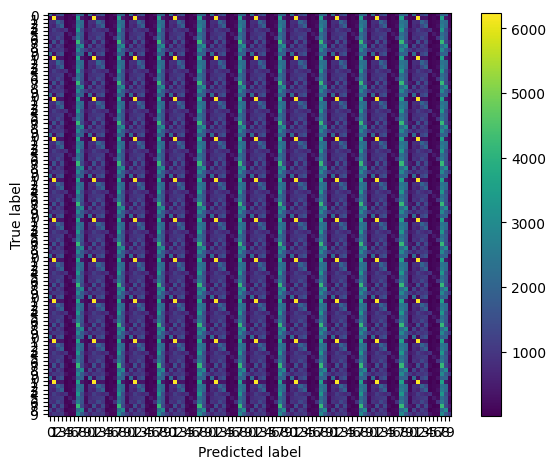

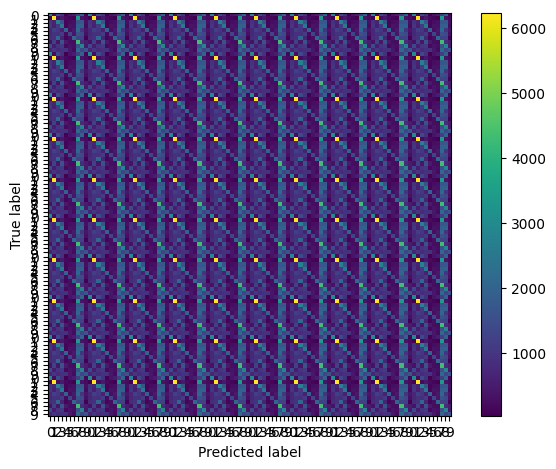

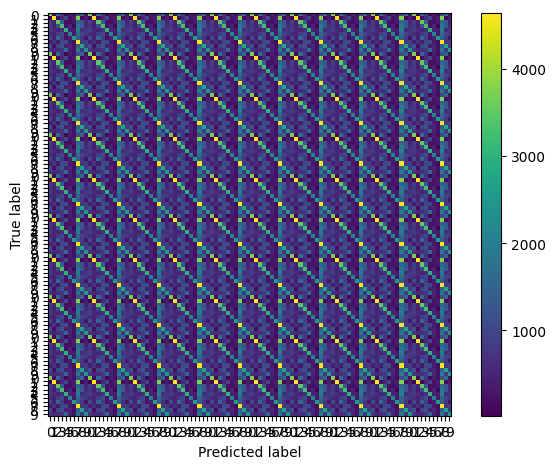

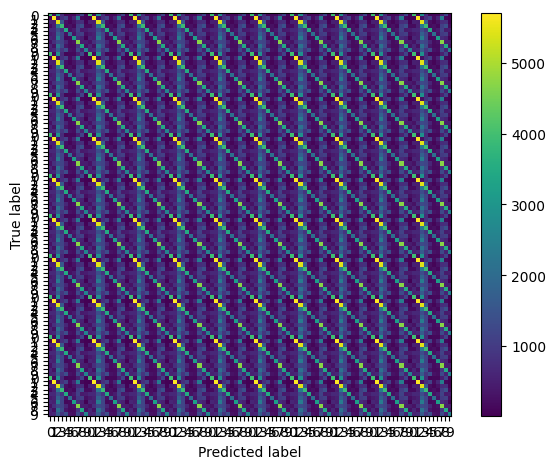

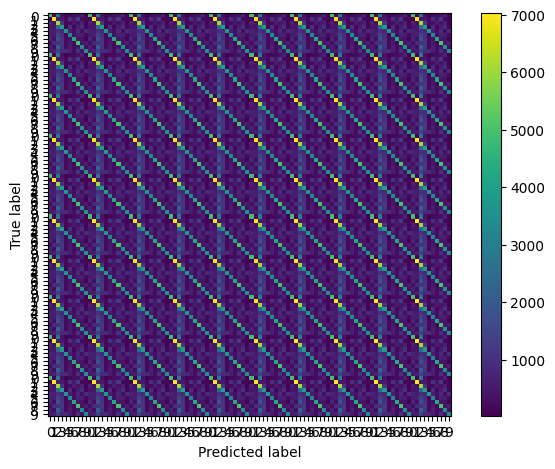

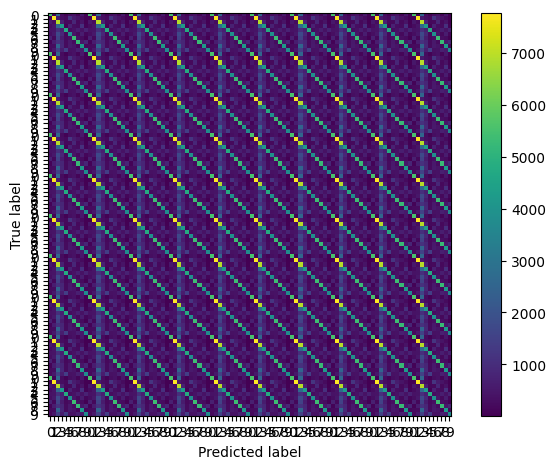

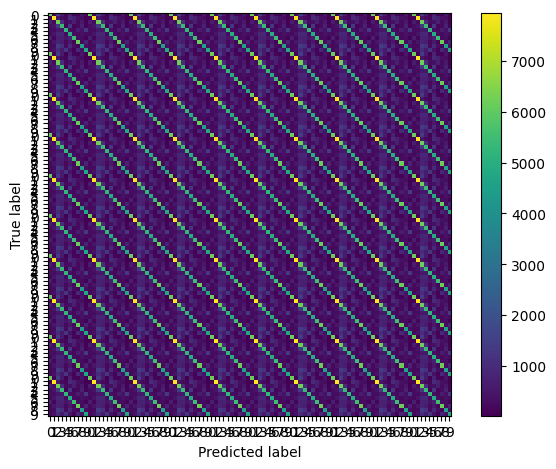

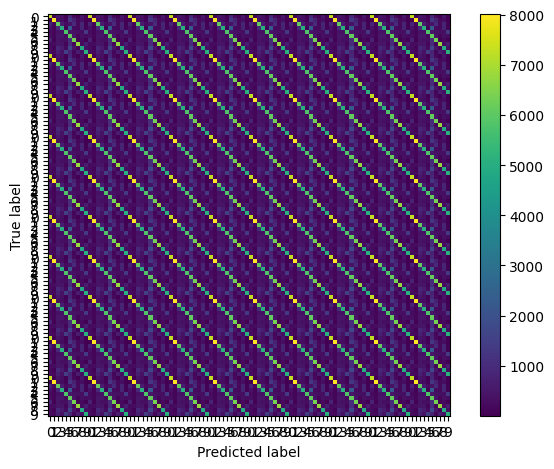

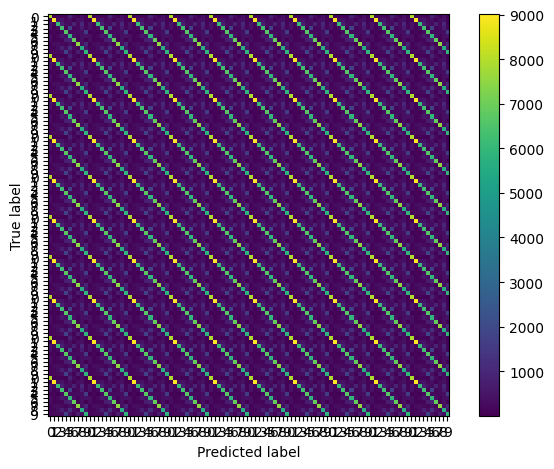

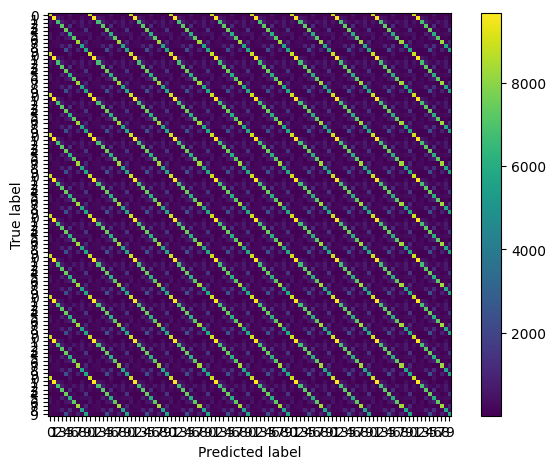

In [11]:
results = list()

for experience in tqdm(train_stream):
    strategy.train(experience)
    metrics = strategy.eval(test_stream)
    results.append(metrics)

# Get metrics

In [12]:
accuracies: dict[int, list[float]] = dict()
forgettings: dict[int, list[float]] = dict()
bwt: dict[int, list[float]] = dict()
class_accuracies: dict[int, list[float]] = dict()
losses: dict[int, list[float]] = dict()

for i in range(10):
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp00{i}"
    ][1]
    forgettings[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceForgetting/eval_phase/test_stream/Task000/Exp00{i}"
    ][1]
    bwt[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceBWT/eval_phase/test_stream/Task000/Exp00{i}"
    ][1]
    class_accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/{i}"
    ][1]
    losses[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Loss_Exp/eval_phase/test_stream/Task000/Exp00{i}"
    ][1]
        

accuracies["Overall"] = eval_plugin.get_all_metrics()[
    "Top1_Acc_Stream/eval_phase/test_stream/Task000"
][1]

In [13]:
train_cpu_usage = eval_plugin.get_all_metrics()["CPUUsage_MB/train_phase/train_stream/Task000"][1]
train_time_epoch = eval_plugin.get_all_metrics()["Time_Epoch/train_phase/train_stream/Task000"][1]
train_running_time = eval_plugin.get_all_metrics()["RunningTime_Epoch/train_phase/train_stream/Task000"][1]
train_loss_epoch = eval_plugin.get_all_metrics()["Loss_MB/train_phase/train_stream/Task000"][1]

In [15]:
all_loss_components = strategy.get_store_loss()

In [16]:
weights = model_plugins[0].weights

# Store metrics

In [17]:
pickle.dump({
    "accuracies": accuracies,
    "forgettings": forgettings,
    "bwt": bwt,
    "class_accuracies": class_accuracies,
    "losses": losses,
    "train_cpu_usage": train_cpu_usage,
    "train_time_epoch": train_time_epoch,
    "train_running_time": train_running_time,
    "train_loss_epoch": train_loss_epoch,
    "all_loss_components": all_loss_components,
    "weights": weights
}, open(SAVED_METRICS_PATH / "mwun.pkl", "wb"))

# Load

In [18]:
metrics = pickle.load(open(SAVED_METRICS_PATH / "mwun.pkl", "rb"))

# Plot metrics

## Accuracy

In [19]:
fig = px.line(
    pd.DataFrame(metrics["accuracies"]),
    title="Accuracy vs Task",
    labels=dict(index="Task", value="Accuracy"),
    width=800,
    height=600,
    range_y=[0, 1],
    markers=True,
)
fig.update_xaxes(type="category")
fig.show()

## Forgetting

In [20]:
forgetting_processed = dict()
for i, (key, value) in enumerate(metrics["forgettings"].items()):
    forgetting_processed[key] = [float("nan")] * i + value

fig = px.line(
    pd.DataFrame(forgetting_processed),
    title="Forgetting vs Task",
    labels=dict(index="Task", value="Forgetting"),
    width=800,
    height=600,
    markers=True,
)
fig.update_xaxes(type="category")
fig.show()

## Losses

In [21]:
fig = px.line(
    pd.DataFrame(metrics["losses"]),
    title="Losses vs Task",
    labels=dict(index="Task", value="Loss"),
    width=800,
    height=600,
    markers=True,
)
fig.update_xaxes(type="category")
fig.show()

## CPU Usage

In [22]:
fig = px.line(
    metrics["train_cpu_usage"],
    title="CPU Usage vs Batch",
    labels=dict(index="Batch", value="Value"),
    width=800,
    height=600,
)
fig.update_xaxes(type="category")
fig.show()

## Time per epoch

In [24]:
fig = px.line(
    metrics["train_time_epoch"],
    title="Time per Epoch vs Epoch",
    labels=dict(index="Epoch", value="Value"),
    width=800,
    height=600,
)
fig.update_xaxes(type="category")
fig.show()

## Running time

In [25]:
fig = px.line(
    metrics["train_running_time"],
    title="Running Time vs Batch",
    labels=dict(index="Batch", value="Value"),
    width=800,
    height=600,
)
fig.update_xaxes(type="category")
fig.show()

## Training loss

In [26]:
fig = px.line(
    metrics["train_loss_epoch"],
    title="Loss vs Batch",
    labels=dict(index="Batch", value="Value"),
    width=800,
    height=600,
)
fig.update_xaxes(type="category")
fig.show()

## All components losses

In [29]:
fig = px.line(
    metrics["all_loss_components"],
    title="Loss Components vs Batch",
    labels=dict(index="Batch", value="Value"),
    width=800,
    height=600,
)
fig.update_xaxes(type="category")
fig.show()

## Weights used

In [30]:
used_weights = list(map(lambda x: sum((abs(x) > 1e-5)).item(), metrics["weights"]))

In [31]:
fig = px.line(
    used_weights,
    title="Used Weights vs Task",
    labels=dict(index="Task", value="Value"),
    width=800,
    height=600,
)
fig.update_xaxes(type="category")
fig.show()